In [56]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from implementations import *
from helper import *
from feature_analysis import *
from expansions import polynomial_expansion
import seaborn as sns
import pandas as pd #temporary
from logistic_regression import *
import disk_helpers

from proj1_helpers import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
DATA_TEST_PATH = '../data/test.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [71]:
np.where([True, False, True])

(array([0, 2]),)

In [95]:


def prepare_y_data(y,x, i_PRI=22) : 
    y_jet0  = y[x[:, i_PRI]==0]
    y_jet1  = y[x[:, i_PRI] == 1]
    y_jet2  = y[x[:, i_PRI] > 1]

    y_jet0 = y_jet0.reshape((len(y_jet0), 1))
    y_jet1 = y_jet1.reshape((len(y_jet1), 1))
    y_jet2 = y_jet2.reshape((len(y_jet2), 1))

    return y_jet0, y_jet1, y_jet2


def prepare_train_data(x, i_PRI=22) : 
    # Replace missing values (-999) with NaN
    x = fix_missing_values(x)
    
    tx_jet0 = x[x[:, i_PRI] ==0]
    tx_jet1 = x[x[:, i_PRI] == 1]
    tx_jet2 = x[x[:, i_PRI] > 1]


    tx_0_filtered = np.delete(tx_jet0, [4,5,6,12,22,23,24,25,26,27,28], axis=1)
    tx_1_filtered = np.delete(tx_jet1, [4,5,6,12,22,26,27,28], axis=1)
    tx_2_filtered = np.delete(tx_jet2, [22], axis=1)

   
    # Treat outliers as missing values (replace with NaN)
    tx_0_filtered = identify_outliers(tx_0_filtered)
    tx_1_filtered = identify_outliers(tx_1_filtered)
    tx_2_filtered = identify_outliers(tx_2_filtered)

    # Compute medians
    medians = []
    medians.append(np.nanmedian(tx_0_filtered, axis=0))
    medians.append(np.nanmedian(tx_1_filtered, axis=0))
    medians.append(np.nanmedian(tx_2_filtered, axis=0))
    

    # Replace missing values (and outliers) with median values
    tx_0_filtered = fix_nan_values(tx_0_filtered, medians[0])
    tx_1_filtered = fix_nan_values(tx_1_filtered, medians[1])
    tx_2_filtered = fix_nan_values(tx_2_filtered, medians[2])


    # Feature engineering
    tx_0 = featureExpand(tx_0_filtered, 0)
    tx_1 = featureExpand(tx_1_filtered, 1)
    tx_2 = featureExpand(tx_2_filtered, 2)

    stds = []
    stds.append(np.std(tx_0, axis=0))
    stds.append(np.std(tx_1, axis=0))
    stds.append(np.std(tx_2, axis=0))

    print("n. colonne stds", len(stds[0]), ", n. colonne tx_0", tx_0.shape[1])
    print("1: ", tx_0[1,:])

    ### TO DO : check
    # Remove columns with standard deviation == 0 (all the values are the same!)
    tx_0, stds[0] = remove_useless_columns(tx_0, stds[0])
    tx_1, stds[1] = remove_useless_columns(tx_1, stds[1])
    tx_2, stds[2] = remove_useless_columns(tx_2, stds[2])
    print("2: ", tx_0[1,:])
    print("n. colonne stds", len(stds[0]), ", n. colonne tx_0", tx_0.shape[1])


    ### END TO DO 

    # Compute means and standard deviations for standardization
    means = []
    means.append(np.mean(tx_0, axis=0))
    means.append(np.mean(tx_1, axis=0))
    means.append(np.mean(tx_2, axis=0))

    # Compute standardization
    tx_0 = standardize(tx_0, means[0], stds[0])
    tx_1 = standardize(tx_1, means[1], stds[1])
    tx_2 = standardize(tx_2, means[2], stds[2])
    print("3: ", tx_0[1,:])

    
    return tx_0, tx_1, tx_2, means, stds, medians

def remove_outliers(y, tx, keep=0.95) : 
    values_to_be_deleted = np.zeros(tx.shape[0]) # At first we keep all
    for column in range(tx.shape[1]) : 
        min_value = np.quantile(tx[:, column],(1-keep)/2)
        max_value = np.quantile(tx[:, column],(1+keep)/2)
        values_to_be_deleted = np.logical_or(values_to_be_deleted, np.logical_or(tx[:, column]<min_value, tx[:, column]>max_value))
    
    values_to_be_kept = np.logical_not(values_to_be_deleted)
    return y[values_to_be_kept, :], tx[values_to_be_kept, :]

In [96]:
tx_train_0, tx_train_1, tx_train_2, means, stds, medians = prepare_train_data(tX)
y_0, y_1, y_2 = prepare_y_data(y, tX)

n. colonne stds 43 , n. colonne tx_0 43
1:  [ 1.00000000e+00  1.75864000e+02  1.69150000e+01  1.34805000e+02
  3.09281465e+04  2.86117225e+02  1.81723880e+04  1.64050000e+01
  1.64050000e+01  5.79830000e+01  2.82090000e+01  2.97740000e+01
  0.00000000e+00  2.69124025e+02  2.69124025e+02  3.36202829e+03
  7.95747681e+02  8.86491076e+02  0.00000000e+00  2.95380000e+01
  5.31310000e+01  8.72493444e+02  2.82290316e+03  4.62949100e+01
  7.59467999e+02  4.77341300e+01  8.07422809e+02  5.99397590e+00
  1.01388102e+02  3.80419710e+02  5.12824790e+04  4.77693125e+01
  6.43954218e+03 -2.34272750e+01 -3.96272357e+02 -2.27209250e+01
 -3.72736775e+02 -6.19751730e+01 -1.74825766e+03  2.37596520e+01
  7.07419879e+02 -3.50832488e+01 -1.03628900e+03]
2:  [ 1.75864000e+02  1.69150000e+01  1.34805000e+02  3.09281465e+04
  2.86117225e+02  1.81723880e+04  1.64050000e+01  1.64050000e+01
  5.79830000e+01  2.82090000e+01  2.97740000e+01  2.69124025e+02
  2.69124025e+02  3.36202829e+03  7.95747681e+02  8.86491

In [97]:
tx_train_0

array([[ 5.74308492e-01,  8.67253094e-01,  6.33891965e-02, ...,
        -5.45141851e-01,  1.26279084e-03,  3.27376837e-04],
       [ 1.28996467e+00, -1.54536822e+00,  2.13573855e+00, ...,
         3.24829378e-01, -1.05717703e-02, -6.79291392e-03],
       [-2.83587688e-01, -2.86954039e-01,  8.34662362e-01, ...,
         1.70599908e-01,  9.55318915e-04,  1.72828436e-04],
       ...,
       [-1.52409806e-01, -1.93691734e-03, -4.31401431e-01, ...,
         1.34476428e-01, -1.69707750e-02, -1.67945957e-02],
       [-5.21915819e-01, -1.45384107e+00, -4.03353035e-01, ...,
        -2.26355213e-01,  4.76073849e-03,  9.60768516e-04],
       [-1.52409806e-01,  5.43298593e-01, -3.25671676e-01, ...,
         1.00158024e+00,  5.18129595e-01,  4.28107158e-01]])

In [ ]:
tx_train_0, tx_train_1, tx_train_2, means, stds, medians = prepare_train_data(tX)
y_0, y_1, y_2 = prepare_y_data(y, tX)

y_0, tx_train_0 = remove_outliers(y_0, tx_train_0)
y_1, tx_train_1 = remove_outliers(y_1, tx_train_1)
y_2, tx_train_2 = remove_outliers(y_2, tx_train_2)

In [21]:
tx_train_0

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [90]:
bs = 999*np.ones(b.shape[1])
fix_nan_values(b, bs)

array([[ 9.99000000e+02,  9.99000000e+02, -2.58282869e-01, ...,
        -3.01179559e-01, -2.84814628e-01, -2.84781100e-01],
       [ 9.99000000e+02,  9.99000000e+02, -3.35563849e-01, ...,
        -2.77540140e-01, -2.84873445e-01, -2.84788258e-01],
       [ 9.99000000e+02,  9.99000000e+02, -2.95254381e-01, ...,
        -2.83601067e-01, -2.84825697e-01, -2.84783644e-01],
       ...,
       [ 9.99000000e+02,  9.99000000e+02, -2.86124725e-01, ...,
        -2.82712533e-01, -2.85471004e-01, -2.85062892e-01],
       [ 9.99000000e+02,  9.99000000e+02, -3.32632055e-01, ...,
        -2.92517283e-01, -2.84688708e-01, -2.84770676e-01],
       [ 9.99000000e+02,  9.99000000e+02, -2.68659765e-01, ...,
        -2.59151030e-01,  3.51175051e+00,  3.51175146e+00]])

# Some tests

/var/folders/23/8yrq68cs22q562ssvdx_frrm0000gn/T/ipykernel_5538/4079174517.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


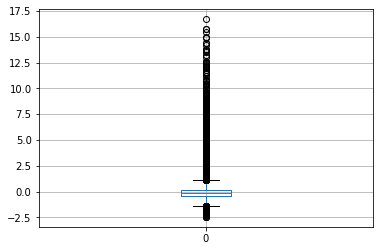

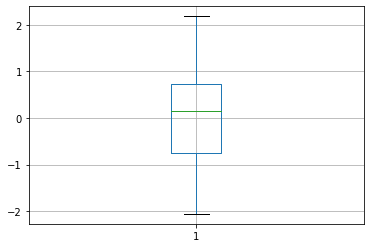

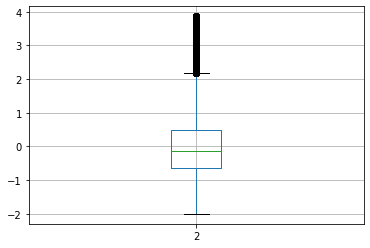

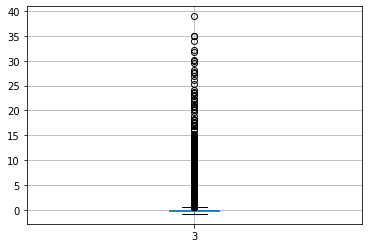

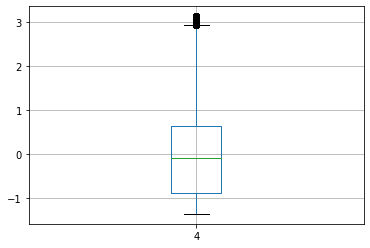

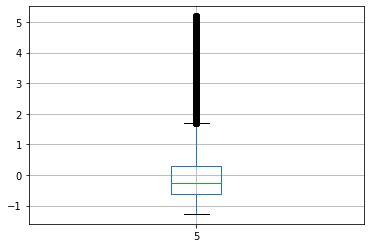

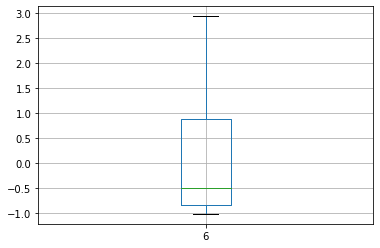

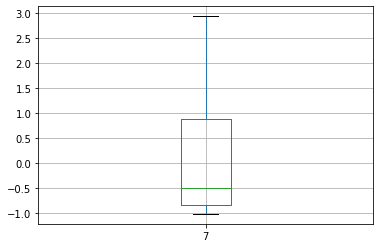

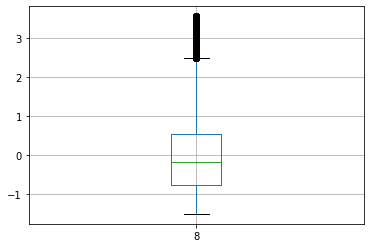

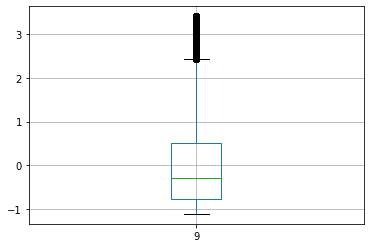

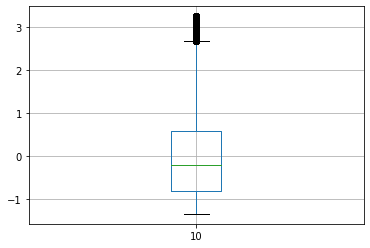

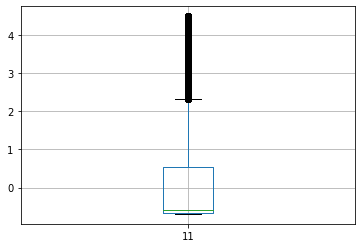

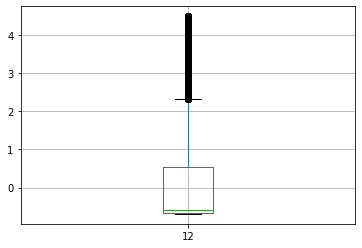

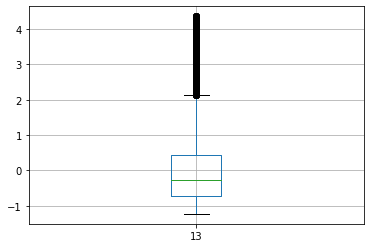

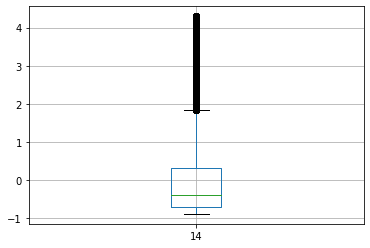

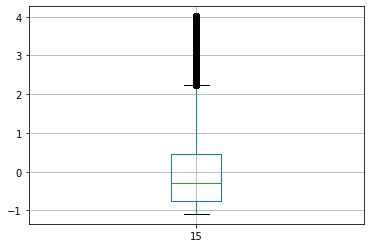

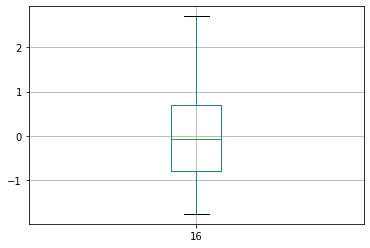

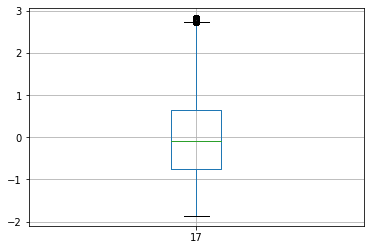

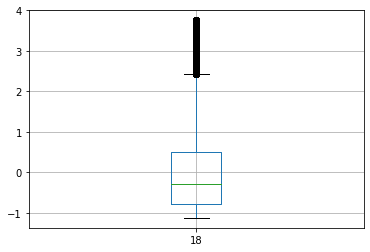

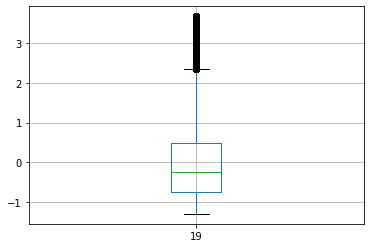

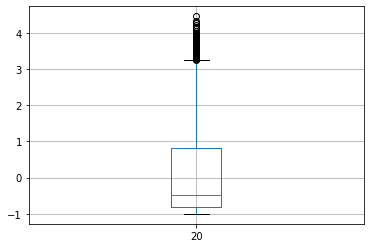

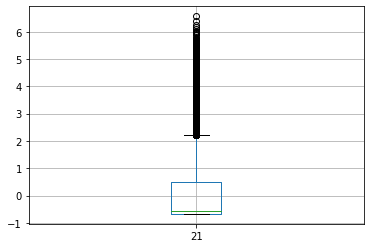

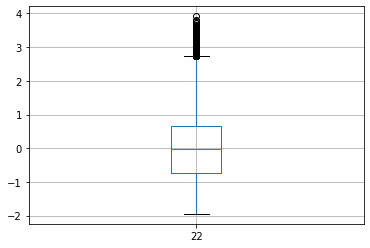

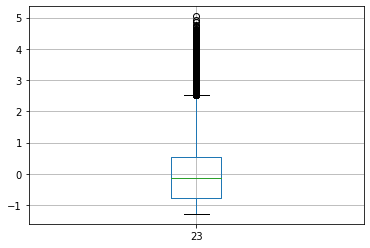

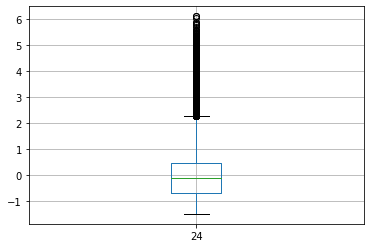

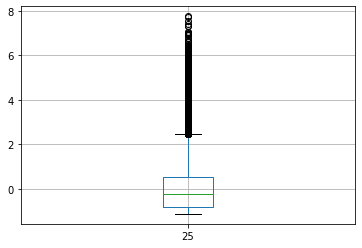

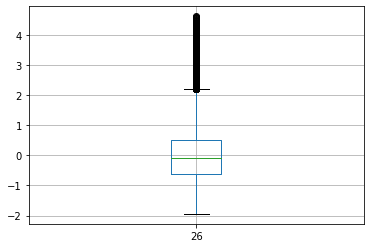

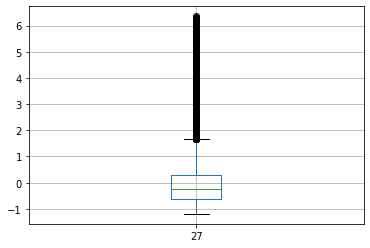

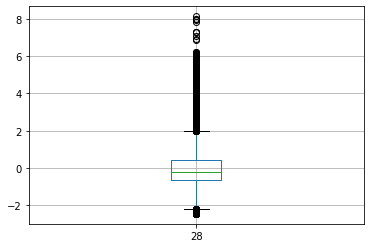

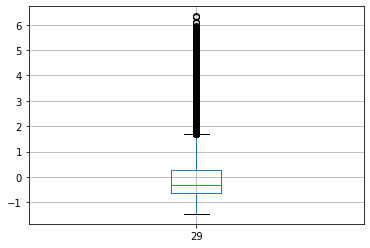

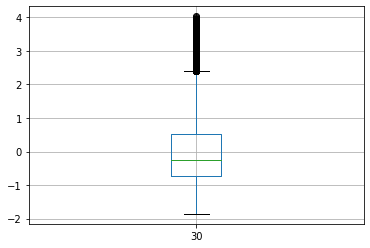

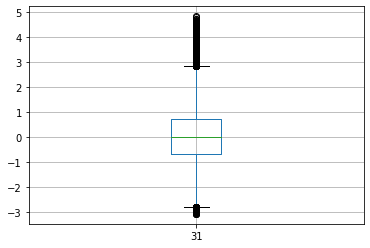

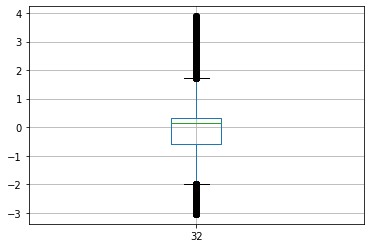

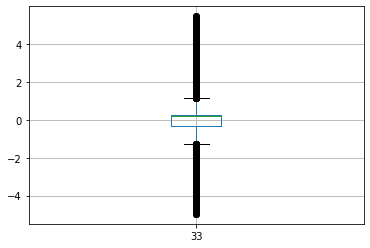

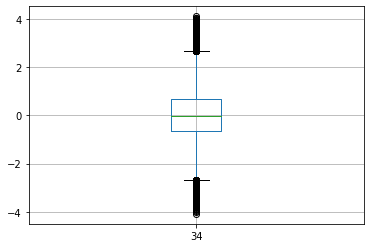

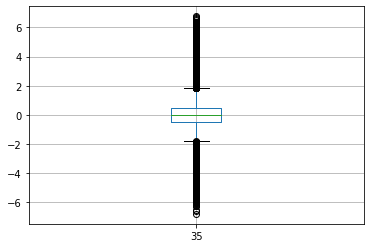

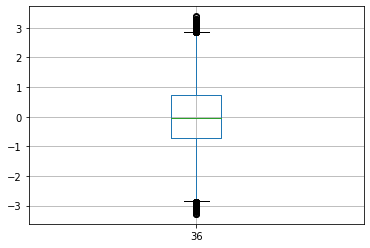

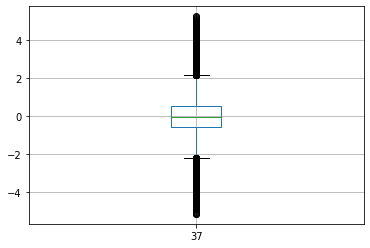

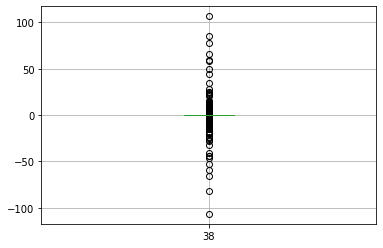

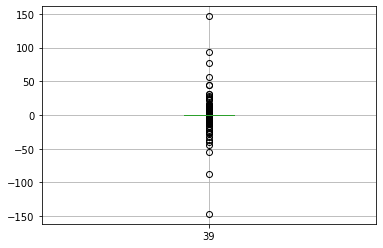

In [98]:
db = pd.DataFrame(tx_train_0)
for column in db : 
    plt.figure()
    db.boxplot([column])


In [ ]:
db.describe()

# Let's find the best model

In [ ]:
def find_best_logistic_regression_model(y, tx, max_iter=20, gamma=0.05, k_fold=3) :
    """Computes the best logistic regression model for the given `y` and `tx`"""

    lambdas = np.logspace(-10, 4, 15)
    degrees = np.arange(1, 7)

    results = np.zeros((len(degrees), len(lambdas)))

    for i_degree, degree in enumerate(degrees) : 
        expanded_tx = polynomial_expansion(tx, degree)
        for i_lambda, lambda_  in enumerate(lambdas) : 
            results[i_degree, i_lambda] = cross_validate_logistic_regression(y, expanded_tx, max_iter, gamma, lambda_, k_fold)
            print("degree={d},\t lambda={l:e},\taccuracy={a}".format(d=degree, l=lambda_, a=results[i_degree, i_lambda]))

    disk_helpers.save_data('logistic-regression', degrees, lambdas, results)
    i,j = np.unravel_index(np.argmax(results, axis=None), results.shape)

    return degrees[i], lambdas[j], results[i, j]

In [ ]:
find_best_logistic_regression_model(y_0, tx_train_0)

In [106]:
from least_squares import cross_validate_least_squares
from plots import plot_degree_errors_plt


def find_best_least_squares_model(y, tx, jet_string, k_fold=4) :
    """Computes the best least squares model for the given `y` and `tx`"""
    lambdas = np.logspace(-15, 10, 26)
    degrees = np.arange(1,20)

    results = np.zeros((len(degrees), len(lambdas)))

    for i_degree, degree in enumerate(degrees) :
        print("build expanded...")
        expanded_tx = polynomial_expansion(tx, degree, mixed_columns=True)
        print("build model...")
        for i_lambda, lambda_  in enumerate(lambdas) : 
            try : 
                results[i_degree, i_lambda] = cross_validate_least_squares(y, expanded_tx, lambda_, k_fold)
                print("degree={d},\t lambda={l:e},\t accuracy={a}".format(d=degree, l=lambda_, a=results[i_degree, i_lambda]))
            except np.linalg.LinAlgError : 
                results[i_degree, i_lambda] = 0
                print("degree={d},\t lambda={l:e},\t accuracy={a}".format(d=degree, l=lambda_, a="0 - singular matrix"))

    i,j = np.unravel_index(np.argmax(results, axis=None), results.shape)
    disk_helpers.save_data('least-squares', jet_string, degrees, lambdas, results)
    plot_degree_errors_plt(degrees, lambdas, results)

    return degrees[i], lambdas[j], results[i, j]

In [108]:
find_best_least_squares_model(y_0, tx_train_0, 'jet0')
#find_best_least_squares_model(y_1, tx_train_1, 'jet1')
#find_best_least_squares_model(y_2, tx_train_2, 'jet2')

build expanded...
build model...
degree=1,	 lambda=1.000000e-15,	 accuracy=0.8458443430218593


KeyboardInterrupt: 

In [ ]:
def find_best_model(y, tx) : 
    """Finds the best model for the given `y` and `tx`"""
    degree_logistic, lambda_logistic, acc_logistic = find_best_logistic_regression_model(y, tx)
    print("Logistic regression: (degree: {d}, lambda: {l}, accuracy: {a})".format(d=degree_logistic, l=lambda_logistic, a=acc_logistic))
    degree_ls, lambda_ls, acc_ls = find_best_least_squares_model(y, tx)
    print("Least squares: (degree: {d}, lambda: {l}, accuracy: {a})".format(d=degree_ls, l=lambda_ls, a=acc_ls))

    if acc_logistic > acc_ls : 
        return "logistic regression", degree_logistic, lambda_logistic, acc_logistic
    else : 
        return "least squares", degree_ls, lambda_ls, acc_ls

In [ ]:
def find_model_for_higgs_dataset() : 
    """Finds the best model for the entire train dataset"""
    
    jet_0_model, jet_0_degree, jet_0_lambda, jet_0_accuracy = find_best_model(y_0, tx_train_0)
    print("Jet0: model={m}, degree={d}, lambda={l}, accuracy={a}".format(m=jet_0_model,d=jet_0_degree,l=jet_0_lambda,a=jet_0_accuracy))
    jet_1_model, jet_1_degree, jet_1_lambda, jet_1_accuracy = find_best_model(y_1, tx_train_1)
    print("Jet1: model={m}, degree={d}, lambda={l}, accuracy={a}".format(m=jet_1_model,d=jet_1_degree,l=jet_1_lambda,a=jet_1_accuracy))
    jet_2_model, jet_2_degree, jet_2_lambda, jet_2_accuracy = find_best_model(y_2, tx_train_2)
    print("Jet2: model={m}, degree={d}, lambda={l}, accuracy={a}".format(m=jet_2_model,d=jet_2_degree,l=jet_2_lambda,a=jet_2_accuracy))


In [ ]:
find_model_for_higgs_dataset()

# Generate predictions

In [36]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [35]:
models = {
    "jet0" : {
        "model" : "least squares",
        "degree" : 5,
        "lambda" : 1e-3,
        "mixed" : False,
        "accuracy" : 0
    },
    "jet1" : {
        "model" : "least squares",
        "degree" : 7,
        "lambda" : 1e-6,
        "mixed" : False,
        "accuracy" : 0.7976 # tx not mixed
    },
    "jet2" : {
        "model" : "least squares",
        "degree" : 6,
        "lambda" : 1e-4,
        "mixed" : False,
        "accuracy" : 0
    }
}

models_new = {
    "jet0" : {
        "model" : "least squares",
        "degree" : 3,
        "lambda" : 0.1,
        "mixed" : False,
        "accuracy" : 0.8355219697727956
    },
    "jet1" : {
        "model" : "least squares",
        "degree" : 7,
        "lambda" : 1e-5,
        "mixed" : False,
        "accuracy" : 0.8043203507866906  
    },
    "jet2" : {
        "model" : "least squares",
        "degree" : 5,
        "lambda" : 0.001,
        "mixed" : False,
        "accuracy" : 0.8258478081058727 
    }
}


models_0_for_Nans = {
 "jet0" : {
        "model" : "least squares",
        "degree" : 3,
        "lambda" : 1e-3,
        "mixed" : True,
        "accuracy" : 0.8473246753246754
    },
    "jet1" : {
        "model" : "least squares",
        "degree" : 4,
        "lambda" : 10000,
        "mixed" : True,
        "accuracy" : 0.79718  
    },
    "jet2" : {
        "model" : "least squares",
        "degree" : 2,
        "lambda" : 0.01,
        "mixed" : False,
        "accuracy" : 0.8307976908110867 
    }
}


models_oggi = {
 "jet0" : {
        "model" : "least squares",
        "degree" : 7,
        "lambda" : 1e-5,
        "mixed" : False,
        "accuracy" : 0.8473246753246754
    },
    "jet1" : {
        "model" : "least squares",
        "degree" : 7,
        "lambda" : 1e-4,
        "mixed" : False,
        "accuracy" : 0.79718  
    },
    "jet2" : {
        "model" : "least squares",
        "degree" : 7,
        "lambda" : 1e-4,
        "mixed" : False,
        "accuracy" : 0.8307976908110867 
    }
}

In [37]:
def compute_weights(models) : 
    """Computes the weights for the given models"""
    weights = []
    y = [y_0, y_1, y_2]  
    tx = [tx_train_0, tx_train_1, tx_train_2]
    for i, (jet, model) in enumerate(models.items()) : 
        x_expanded = polynomial_expansion(tx[i], model["degree"], model["mixed"])
        if model["model"] == "least squares" : 
            w, err = ridge_regression(y[i], x_expanded, model["lambda"])
            weights.append(w)
        elif model["model"] == "logistic regression" : 
            w = logistic_regression_penalized_gradient_descent(y[i], x_expanded, 0.01, model["lambda"], 30)
            weights.append(w)
        else : 
            raise Exception("Model not recognised")
        print("weights computed for", jet)
            
    return weights[0], weights[1], weights[2]

In [38]:
def predict(models, x_test) : 
    """Makes the prediction given the models chosen and the test dataset"""
    i_PRI = 22
    print("prepare dataset...")
    x_test_0, x_test_1, x_test_2 = prepare_x_data(x_test)
    print("compute weights...")
    w_0, w_1, w_2 = compute_weights(models)
    print("compute predictions...")
    x_test_0 = polynomial_expansion(x_test_0, models["jet0"]["degree"], mixed_columns=models["jet0"]["mixed"])
    x_test_1 = polynomial_expansion(x_test_1, models["jet1"]["degree"], mixed_columns=models["jet1"]["mixed"])
    x_test_2 = polynomial_expansion(x_test_2, models["jet2"]["degree"], mixed_columns=models["jet2"]["mixed"])

    y_0_predicted = predict_labels(w_0, x_test_0)
    y_1_predicted = predict_labels(w_1, x_test_1)
    y_2_predicted = predict_labels(w_2, x_test_2)

    y_pred = np.zeros((len(x_test), 1))
    y_pred[x_test[:, i_PRI]==0] = y_0_predicted
    y_pred[x_test[:, i_PRI]==1] = y_1_predicted
    y_pred[x_test[:, i_PRI]>=2] = y_2_predicted

    return y_pred

In [39]:
OUTPUT_PATH="out9.csv"
y_pred = predict(models_oggi, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

prepare dataset...
compute weights...
weights computed for jet0
weights computed for jet1
weights computed for jet2
compute predictions...
saving predictions on file...
predictions saved on  out9.csv


# Estimation
We can estimate the accuracy of our model on the test dataset without uploading data su AIcrowd

In [ ]:
def estimation(models) : 
    """ Estimates the accuracy of our model on the test dataset without uploading to AIcrowd """
    i_PRI = 22
    n_0 = sum(tX_test[:, i_PRI]==0)
    n_1 = sum(tX_test[:, i_PRI]==1)
    n_2 = sum(tX_test[:, i_PRI]>=2)

    accuracy = (n_0*models["jet0"]["accuracy"] + n_1*models["jet1"]["accuracy"] + n_2*models["jet2"]["accuracy"])/(len(tX_test))

    print("The estimate accuracy with the given model is", round(accuracy, 5))

In [ ]:
estimation(models_new)